In [1]:
# !pip install lava-nc
# !pip install networkx==2.8
# !pip install matplotlib
# !pip install cvxpy
# !pip install lava-nc
# !pip install pandas


In [2]:
import lava
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mod_one_exchange import mod_one_exchange_approximation
import graph_col_dimacs_reader as reader
import goemans_williamson_sdp as gw_sdp
import scipy
import matplotlib
import re
import time

In [4]:
def random_cut(G):
    colors = np.random.randint(2, size = G.number_of_nodes())
    cutsize = 0
    for u,v in G.edges():
        if colors[u] != colors[v]:
            cutsize += 1
    return colors, cutsize

def graph_to_mat(G, path = 'test_graphs/default2.mat'):
    # get the adjancency matrix of the graph
    adj = nx.adjacency_matrix(G).todense()
    adj = np.asarray(adj, dtype=np.int32)
    scipy.io.savemat(path, {'M': adj})   # M for matrix, to stay consistent with the .mat files we already have
    return

def mat_to_graph(path):
    mat = scipy.io.loadmat(path)
    G = nx.from_numpy_matrix(mat['M'])
    return G
# The function below would be useful to read temporary results from the subgraphs
def extract_chromatic_info(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    
    # Extract minimum order-based chromatic number using regex
    min_chromatic_number = int(re.search(r"minimum order-based chromatic number during simulation:  (\d+)", text).group(1))
    
    # Extract color blocks at minimum chromatic number using regex
    color_blocks_str = re.search(r"color blocks at minimum chromatic number:  (\[\[.*\]\])", text).group(1)
    color_blocks = eval(color_blocks_str)  # When you pass the string representation of a list of lists to eval(), 
    # it parses the string and converts it into actual Python objects (in this case, a list of lists of integers).
    
    return min_chromatic_number, color_blocks

In [36]:
col_graph_name = 'dsjc125.5'
G,adj,nnodes = reader.dimacs_reader("test_graphs/{}.col".format(col_graph_name))
# Save as .mat file
graph_to_mat(G, 'test_graphs/{}.mat'.format(col_graph_name))


/tmp/ipykernel_9273/392366149.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()


In [6]:
# Example
# min_chromatic_number_without_maxcut, color_blocks = extract_chromatic_info('temp_output7.txt')

# print(min_chromatic_number_without_maxcut)
# print(color_blocks)
# G,adj,nnodes = reader.dimacs_reader("test_graphs/dsjc250.5.col")
# colors,cutsize = mod_one_exchange_approximation(G)
# colors,cutsize = gw_sdp.goemans_williamson_max_cut(G)
# colors,cutsize = random_cut(G)

In [7]:
def get_subgraphs(G, maxcut_colors):
    # maxcut_colors contain 0s and 1s
    # 0s are the nodes in the first set
    # 1s are the nodes in the second set
    # create two maps, one for each set
    # We proceed in ascending order over the original graph and assign the nodes to the sets
    # according to the maxcut_colors
    first_set = []
    second_set = []
    for i in range(len(maxcut_colors)):
        if maxcut_colors[i] == 0:
            first_set.append(i)
        else:
            second_set.append(i)

    # create the adjacency matrix for the subgraphs
    #
    adj = nx.adjacency_matrix(G).todense()
    adj = np.asarray(adj, dtype=np.int32)

    adj_sub1 = np.zeros((len(first_set), len(first_set)))
    adj_sub2 = np.zeros((len(second_set), len(second_set)))

    for i in range(len(first_set)):
        for j in range(len(first_set)):
            adj_sub1[i][j] = adj[first_set[i]][first_set[j]]

    for i in range(len(second_set)):
        for j in range(len(second_set)):
            adj_sub2[i][j] = adj[second_set[i]][second_set[j]]

    # create the subgraphs
    G_sub1 = nx.from_numpy_matrix(adj_sub1)
    G_sub2 = nx.from_numpy_matrix(adj_sub2)

    return G_sub1, G_sub2, first_set, second_set

In [8]:
def check_validity(G_sub1,G_sub2,G,color_blocks1,color_blocks2,cut,part1,part2):
    colors1 = np.zeros(G_sub1.number_of_nodes())
    colors2 = np.zeros(G_sub2.number_of_nodes())
    color_index = 0
    for i,block in enumerate(color_blocks1):
        for node in block:
            colors1[node] = color_index
        color_index += 1
    for i,block in enumerate(color_blocks2):
        for node in block:
            colors2[node] = color_index
        color_index += 1

    # check if the coloring is valid
    valid_coloring1 = True
    valid_coloring2 = True
    for edges in G_sub1.edges:
        if colors1[edges[0]] == colors1[edges[1]]:
            valid_coloring1 = False
            print("Invalid coloring for subgraph 1")
            print(edges)
    for edges in G_sub2.edges:
        if colors2[edges[0]] == colors2[edges[1]]:
            valid_coloring2 = False
            print("Invalid coloring for subgraph 2")
            print(edges)

    if(valid_coloring1):
        print("Valid coloring for subgraph 1")
    if(valid_coloring2):
        print("Valid coloring for subgraph 2")

    # combine the two colorings
    # Using two pointers approach
    i = 0
    j = 0
    k = 0

    merged_colors = np.zeros(G.number_of_nodes())
    
    while i < G_sub1.number_of_nodes() and j < G_sub2.number_of_nodes():
        if cut[k] == 0:
            merged_colors[part1[i]] = colors1[i]
            i += 1
        else:
            merged_colors[part2[j]] = colors2[j]
            j += 1
        k += 1
    while i < G_sub1.number_of_nodes():
        merged_colors[part1[i]] = colors1[i]
        i += 1
        k += 1

    while j < G_sub2.number_of_nodes():
        merged_colors[part2[j]] = colors2[j]
        j += 1
        k += 1

    # check if the coloring is valid
    valid_coloring = True
    for edges in G.edges:
        if merged_colors[edges[0]] == merged_colors[edges[1]]:
            valid_coloring = False
            print("Invalid coloring for full Graph")
            print(edges)
    if valid_coloring:
        print("Valid coloring for full Graph")
    return merged_colors


def check_reducibility(num_colors, merged_colors, G):
    color_adj = np.zeros((num_colors, num_colors))
    for edges in G.edges():
        color_adj[int(merged_colors[edges[0]])][int(merged_colors[edges[1]])] = 1
        color_adj[int(merged_colors[edges[1]])][int(merged_colors[edges[0]])] = 1
    
    temp_check = np.ones((num_colors,num_colors))-np.eye(num_colors)
    flag = np.array_equal(color_adj,temp_check)
    if flag:
        print("Not reducible")
    else:
        print("Reducible")
    
    print(color_adj)
    return flag, color_adj


def min_chromatic_number(G):
    # Use networkx's greedy_color algorithm to assign colors # Might not be complete
    color_assignment = nx.coloring.greedy_color(G, strategy="largest_first")
    
    # The chromatic number is the maximum color index used + 1
    chromatic_number = max(color_assignment.values()) + 1
    
    # Returning chromatic number and color assignment for nodes
    return chromatic_number, color_assignment


In [37]:
number_of_runs = 4
graph_coloring_min_colors = []
graph_coloring_with_MOE_cut_min_colors = []
graph_coloring_with_MOE_cut_min_colors_optimized = []
graph_coloring_with_random_cut_min_colors = []
graph_coloring_with_random_cut_min_colors_optimized = []
graph_coloring_with_goeman_williamson_min_colors = []
graph_coloring_with_goeman_williamson_min_colors_optimized = []
is_reducible_MOE = []
is_reducible_random_cut = []
is_reducible_goeman_williamson = []

for i in range (1, number_of_runs + 1):
    print("Running for", i, "th time")
    graph_name = 'dsjc125.5'
    G = mat_to_graph('test_graphs/' + graph_name + '.mat')
    
    !python GraphColoringTest.py dsjc125.5 0.01 > temp_output.txt

    min_chromatic_number_without_maxcut, color_blocks = extract_chromatic_info('temp_output.txt')
    graph_coloring_min_colors.append(min_chromatic_number_without_maxcut)
    
    # Running the MOE algorithm
    cut, cutsize = mod_one_exchange_approximation(G)
    G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    cut_sub1, cutsize_sub1 = mod_one_exchange_approximation(G_sub1)
    cut_sub2, cutsize_sub2 = mod_one_exchange_approximation(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_MOE_cut_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_MOE.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_MOE_cut_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_MOE_cut_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)



    # Running the random cut algorithm
    cutsize = 0
    while(cutsize == 0):  # We want to make sure that the subsets are non-empty
        cut, cutsize = random_cut(G)
        G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    

    cut_sub1, cutsize_sub1 = random_cut(G_sub1)
    cut_sub2, cutsize_sub2 = random_cut(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_random_cut_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_random_cut.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_random_cut_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_random_cut_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

        
    # Running the Goemans-Williamson algorithm
    cut, cutsize = gw_sdp.goemans_williamson_max_cut(G)
    G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    cut_sub1, cutsize_sub1 = gw_sdp.goemans_williamson_max_cut(G_sub1)
    cut_sub2, cutsize_sub2 = gw_sdp.goemans_williamson_max_cut(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_goeman_williamson_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_goeman_williamson.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_goeman_williamson_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_goeman_williamson_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

Running for 1 th time


/tmp/ipykernel_9273/3790719680.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_9273/392366149.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()


Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


/home/kunal/Desktop/Sem_9/DDP/Maxcut/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
Running for 2 th time
Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 0. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 0. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 0. 0. ... 1. 1. 0.]]
Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 

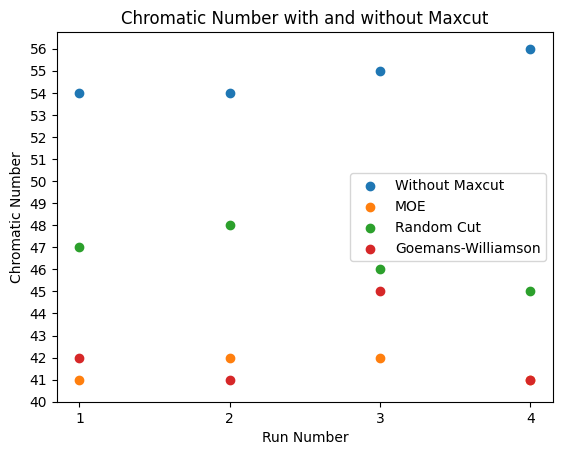

In [38]:
# Making a scatter plot, one for with maxcut and one for without maxcut
# only show integer ticks on the y-axis and x-axis
plt.figure()
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors, label = 'MOE')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors, label = 'Random Cut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors, label = 'Goemans-Williamson')
plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors), 
                         min(graph_coloring_with_random_cut_min_colors), 
                         min(graph_coloring_with_goeman_williamson_min_colors))-1, 
                    max(max(graph_coloring_min_colors), 
                        max(graph_coloring_with_MOE_cut_min_colors), 
                        max(graph_coloring_with_random_cut_min_colors), 
                        max(graph_coloring_with_goeman_williamson_min_colors))+1))
plt.xlabel('Run Number')
plt.ylabel('Chromatic Number')
plt.legend()
plt.title('Chromatic Number with and without Maxcut')
plt.show()


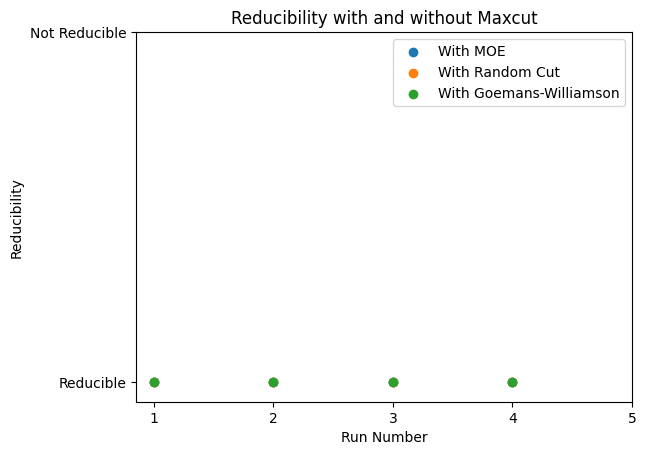

In [39]:
# make a scatter plot for reducibility
plt.figure()
plt.scatter(range(1, number_of_runs + 1), is_reducible_MOE, label = 'With MOE')
plt.scatter(range(1, number_of_runs + 1), is_reducible_random_cut, label = 'With Random Cut')
plt.scatter(range(1, number_of_runs + 1), is_reducible_goeman_williamson, label = 'With Goemans-Williamson')
plt.xticks(range(1, number_of_runs + 2))
plt.yticks([0,1], ['Reducible', 'Not Reducible'])
plt.xlabel('Run Number')
plt.ylabel('Reducibility')
plt.legend()
plt.title('Reducibility with and without Maxcut')
plt.show()

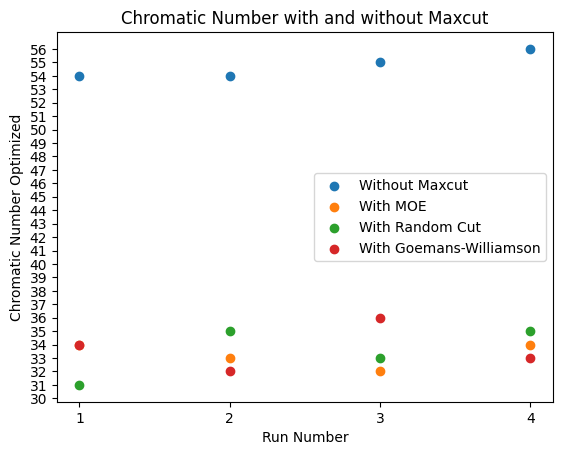

In [46]:
# Making a scatter plot, one for with maxcut and one for without maxcut
# only show integer ticks on the y-axis and x-axis
plt.figure()
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors_optimized, label = 'With MOE')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors_optimized, label = 'With Random Cut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors_optimized, label = 'With Goemans-Williamson')
plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors_optimized),
                         min(graph_coloring_with_random_cut_min_colors_optimized),
                         min(graph_coloring_with_goeman_williamson_min_colors_optimized))-1,
                    max(max(graph_coloring_min_colors),
                        max(graph_coloring_with_MOE_cut_min_colors_optimized),
                        max(graph_coloring_with_random_cut_min_colors_optimized),
                        max(graph_coloring_with_goeman_williamson_min_colors_optimized))+1))

plt.xlabel('Run Number')
plt.ylabel('Chromatic Number Optimized')
plt.legend()
plt.title('Chromatic Number with and without Maxcut')
plt.show()


In [41]:
# save all the results in a dataframe
import pandas as pd
results = pd.DataFrame({'graph_coloring_min_colors': graph_coloring_min_colors,
                        'graph_coloring_with_MOE_cut_min_colors': graph_coloring_with_MOE_cut_min_colors,
                        'graph_coloring_with_random_cut_min_colors': graph_coloring_with_random_cut_min_colors,
                        'graph_coloring_with_goeman_williamson_min_colors': graph_coloring_with_goeman_williamson_min_colors,
                        'is_reducible_MOE': is_reducible_MOE,
                        'is_reducible_random_cut': is_reducible_random_cut,
                        'is_reducible_goeman_williamson': is_reducible_goeman_williamson,
                        'graph_coloring_with_MOE_cut_min_colors_optimized': graph_coloring_with_MOE_cut_min_colors_optimized,
                        'graph_coloring_with_random_cut_min_colors_optimized': graph_coloring_with_random_cut_min_colors_optimized,
                        'graph_coloring_with_goeman_williamson_min_colors_optimized': graph_coloring_with_goeman_williamson_min_colors_optimized})

# Save by the name of the graph
results.to_csv('results_' + graph_name + '.csv')


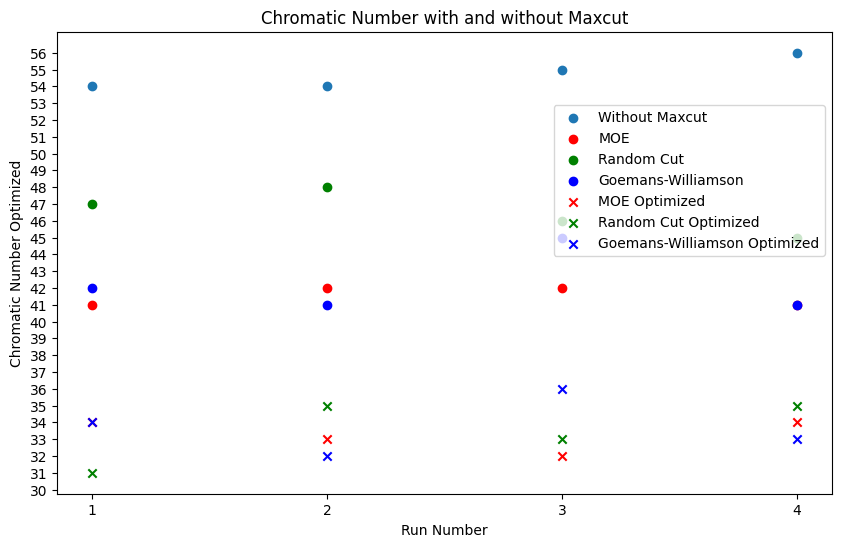

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors, label = 'MOE', marker = 'o', color = 'r')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors, label = 'Random Cut', marker = 'o', color = 'g')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors, label = 'Goemans-Williamson', marker = 'o', color = 'b')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors_optimized, label = 'MOE Optimized', marker = 'x', color = 'r')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors_optimized, label = 'Random Cut Optimized', marker = 'x', color = 'g')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors_optimized, label = 'Goemans-Williamson Optimized', marker = 'x', color = 'b')

plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors_optimized),
                         min(graph_coloring_with_random_cut_min_colors_optimized),
                         min(graph_coloring_with_goeman_williamson_min_colors_optimized))-1,
                    max(max(graph_coloring_min_colors),
                        max(graph_coloring_with_MOE_cut_min_colors_optimized),
                        max(graph_coloring_with_random_cut_min_colors_optimized),
                        max(graph_coloring_with_goeman_williamson_min_colors_optimized))+1))

plt.xlabel('Run Number')
plt.ylabel('Chromatic Number Optimized')
# show legend seperately
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Chromatic Number with and without Maxcut')
plt.show()

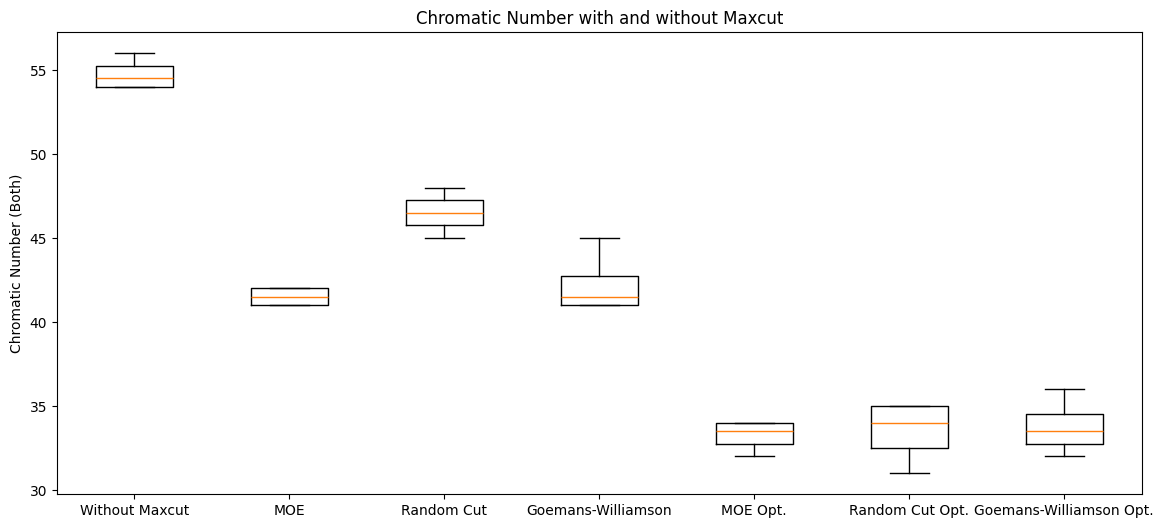

In [43]:
plt.figure(figsize=(14, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors, graph_coloring_with_random_cut_min_colors, 
             graph_coloring_with_goeman_williamson_min_colors, graph_coloring_with_MOE_cut_min_colors_optimized, 
             graph_coloring_with_random_cut_min_colors_optimized, graph_coloring_with_goeman_williamson_min_colors_optimized])
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Without Maxcut', 'MOE', 'Random Cut', 'Goemans-Williamson',
                           'MOE Opt.', 'Random Cut Opt.', 'Goemans-Williamson Opt.'])
plt.ylabel('Chromatic Number (Both)')

plt.title('Chromatic Number with and without Maxcut')
plt.show()

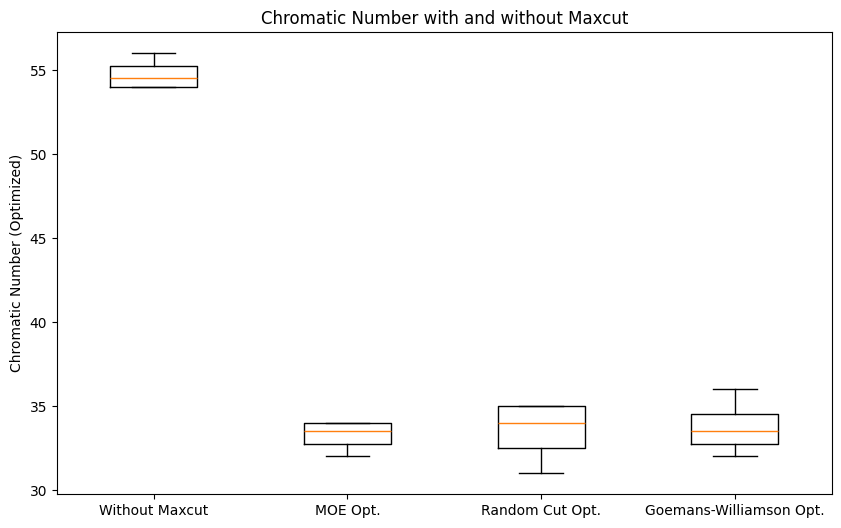

In [44]:
# Making a box plot, one for maxcut with each method and one for without maxcut

plt.figure(figsize=(10, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors_optimized, graph_coloring_with_random_cut_min_colors_optimized, graph_coloring_with_goeman_williamson_min_colors_optimized])
plt.xticks([1, 2, 3, 4], ['Without Maxcut', 'MOE Opt.', 'Random Cut Opt.', 'Goemans-Williamson Opt.'])
plt.ylabel('Chromatic Number (Optimized)')

plt.title('Chromatic Number with and without Maxcut')
plt.show()

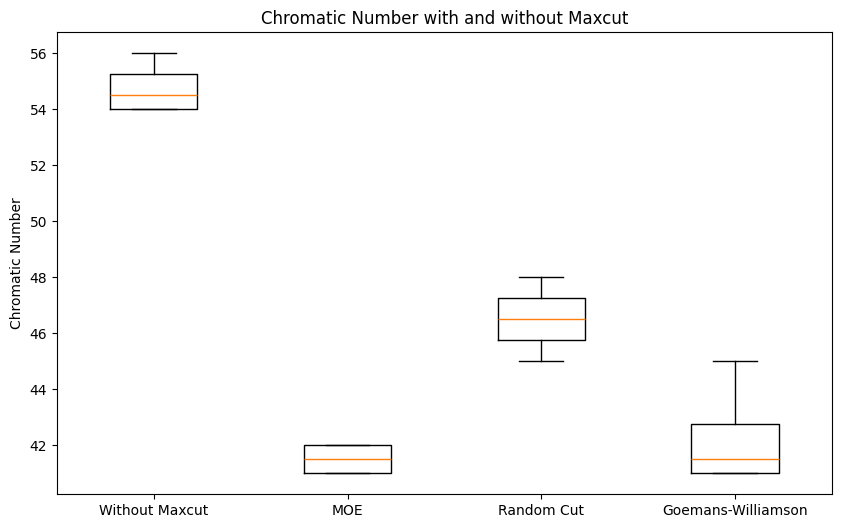

In [45]:
# Making a box plot, one for maxcut with each method and one for without maxcut

plt.figure(figsize=(10, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors, graph_coloring_with_random_cut_min_colors, graph_coloring_with_goeman_williamson_min_colors])
plt.xticks([1, 2, 3, 4], ['Without Maxcut', 'MOE', 'Random Cut', 'Goemans-Williamson'])
plt.ylabel('Chromatic Number')

plt.title('Chromatic Number with and without Maxcut')
plt.show()